In [5]:
import numpy as np
import logging 
import time 
from datetime import datetime
import json
from pathlib import Path

from src import ParameterSet, Plot
from src import ModelBase as Model
from src.integral import itoint

from src.model_base import ModelBase
import matplotlib.pyplot as plt

# np.seterr(all='raise')
np.set_printoptions(precision=4, suppress=True, linewidth=200)
logging.basicConfig(level=logging.WARN)

from scipy.fft import fft, fftfreq
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt


In [6]:
def run(t_end, changes = {}, *, dt=0.001, path:Path=None, params_set = "abh_values.json"):
    #print(f'estimated time: {1.1 * t_end/dt / 1000} seconds')
    t_start = time.time()
    t = np.linspace(0, t_end, int(t_end / dt) + 1)
    y0 = Model()
    y0.initialize()
    if params_set == None:
        params = ParameterSet("smallcirtuit.json")
    else:
        params = ParameterSet(params_set)
        print("Params set to", params_set)
    params.batch_update(changes)
    #params.J.print_matrix()
    #params.J_ampa.print_matrix()
    #print(json.dumps(params.__flat_json__(ignore_zeros=True), indent=2))
    if path is not None:
        params.save(path / 'params.json')
        params.saveDelta(path / 'params_delta.json',base_file='structure.json')
        params.saveDeltaHtml(path / 'params_delta.html',base_file='structure.json')
        params.saveHtml(path / 'params.html',keys = [])

    def calc_g_static():
      sigma = y0.serialize_g(params)
      g_vector = sigma * params.constants.tau_y
      g_matrix = np.diag(g_vector)
      g_matrix = g_matrix[:,~np.all(g_matrix == 0, axis=0)]
      g_matrix = g_matrix * 1.0
      return g_matrix
    
    g_matrix = calc_g_static()

    def model_f(y, t):
        Y = Model().deserialize(y)
        delta = Y.calcDelta(t, params)
        dy = delta.serialize()
        return dy

    def model_g(y, t):
        # Y = MyState().deserialize(y)
        # sigma = Y.serialize_g(params)
        # tau_y = params.constants.tau_y
        # g = sigma * tau_y
        # return np.diag(g_vector)
        return g_matrix.copy()

    # gen = np.random.Generator(np.random.PCG64(123))
    gen = None
    # res = sdeint.itoint(model_f, model_g, y0.serialize(), t, gen)
    res = itoint(model_f, model_g, y0.serialize(), t, gen)
    def toState(y): return Model().deserialize(y)
    t_end = time.time()
    #print(f'elapsed time: {t_end - t_start} seconds')
    return t, list(map(toState, res))

C:\Users\palavia\AppData\Local\Temp\ipykernel_28276\4251932794.py:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='Disconnected.json' mode='r' encoding='cp1252'>
  params = ParameterSet(params_set)


Params set to Disconnected.json


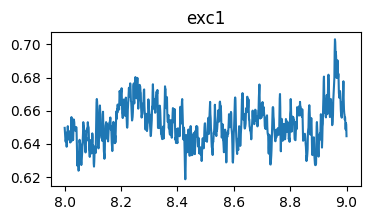

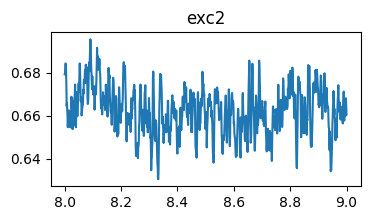

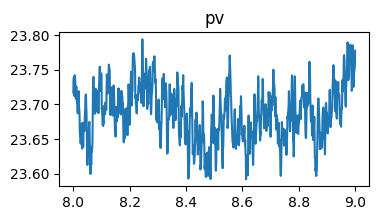

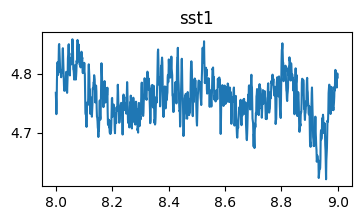

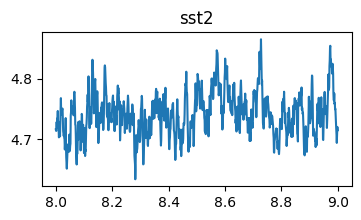

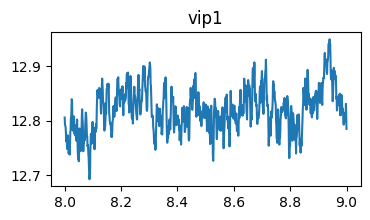

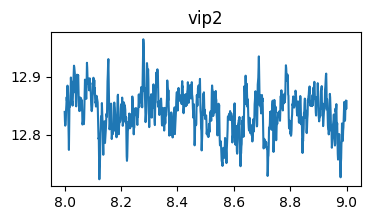

In [15]:
e= 0.432
p= 0.4
s= 0.35
v= 0.16
cut_off_exc_to_rest={"J.sst1.exc1":0.0, "J.sst2.exc2":0.0,"J.vip1.exc1":0.0, "J.vip2.exc2":0.0}
experiment = {"exc1.I_back.dc":e, "exc2.I_back.dc":e,"pv.I_back.dc":p,"sst1.I_back.dc":s,"sst2.I_back.dc":s,"vip1.I_back.dc":v,"vip2.I_back.dc":v}
experiment.update(cut_off_exc_to_rest)

t, res = run(10, changes = experiment , dt=0.001, path=None, params_set="Disconnected.json")

p=[]
p.append(Plot(['exc1.r'],t_start = 8, t_end=9 , title = "exc1"))
p.append(Plot(['exc2.r'],t_start = 8, t_end=9 , title = "exc2"))
p.append(Plot(['pv.r'],t_start = 8, t_end=9 , title = "pv"))
p.append(Plot(['sst1.r'],t_start = 8, t_end=9 , title = "sst1"))
p.append(Plot(['sst2.r'],t_start = 8, t_end=9 , title = "sst2"))
p.append(Plot(['vip1.r'],t_start = 8, t_end=9 , title = "vip1"))
p.append(Plot(['vip2.r'],t_start = 8, t_end=9 , title = "vip2"))
plt.rcParams['figure.figsize'] = [4, 2]
for i in p:
    i(t,res)
    

In [16]:
if __name__ == '__main__':
    exp = 'reduced_circuit_firing_rates'
    print(experiment)
    dt = datetime.now()
    folder = Path(f'img/{exp}/{dt.strftime("%Y-%m-%d")}/{dt.strftime("%H%M%S")}')
    #folder = Path(f'img/{exp}/{dt.strftime("%Y-%m-%d")}/highampa_theta')
    folder.mkdir(parents=True)
    t, res = run(30, changes = experiment , dt=0.0005, path=folder, params_set="Disconnected.json")
    #exc1_r = np.array([x.exc1.r for x in res])
    plots = [
        Plot(['exc1.r'], t_start=1, t_end=30, title='Exc 1 Firing Rate', file=folder / 'r1.svg'),
        Plot(['exc2.r'], t_start=1, t_end=30, title='Exc 2 Firing Rate', file=folder / 'r2.svg'),
        Plot(['pv.r'],   t_start=1, t_end=30, title='PV Firing Rate',    file=folder / 'pv.svg'),
        Plot(['sst1.r'], t_start=1, t_end=30, title='SST 1 Firing Rate', file=folder / 's1.svg'),
        Plot(['sst2.r'], t_start=1, t_end=30, title='SST 2 Firing Rate', file=folder / 's2.svg'),
        Plot(['vip1.r'], t_start=1, t_end=30, title='VIP 1 Firing Rate', file=folder / 'v1.svg'),
        Plot(['vip2.r'], t_start=1, t_end=30, title='VIP 2 Firing Rate', file=folder / 'v2.svg'),
        #Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 PAC', file=folder / 'pac.svg',plot_type= "pac"),
        Plot(['exc1.r'], t_start=1, t_end=30, title='Exc 1 fft no transient', file=folder / 'fft.svg',plot_type= "fft"),
        #Plot(['exc1.r'], t_start=0.0, t_end=10, title='Exc 1 fft', file=folder / 'fft.svg',plot_type= "fft"),
        #Plot(['exc1.r'], t_start=9.5, t_end=10, title='Exc 1 fft', file=folder / 'fft.svg',plot_type= "fft"),
        #Plot(['exc1.r'], t_start=2, t_end=3, title='Exc 1 Firing Rate', file=folder / 'r1-before.svg'),
        # Plot(['exc1.r'], t_start=5, t_end=6, title='Exc 1 Firing Rate', file=f'{folder}/r1-during.png'),
        # Plot(['exc1.r'], t_start=7, t_end=8, title='Exc 1 Firing Rate', file=f'{folder}/r1-after.png'),
        # Plot(['exc1.r','exc2.r','pv.r'], t_start=3, t_end=7, title='Exc 1, 2, PV Firing Rate', file=f'{folder}/r1-r2.png'),
    ]
    for p in plots:
        if p.plot_type == "fft":
            p(t,res,max_fq = 50)
        else:
            p(t,res)
    plots_ref = [p.file.name for p in plots]
    plots_ref = [f'<div class="res-img"><img src="{p}"/></div>' for p in plots_ref]
    plots_ref = '\n'.join(plots_ref)

    html = folder / 'results.html'
    html.write_text(f'''<html>
<head>
    <title> Summary </title>
    <style>
    .images {{display: flex; flex-wrap: wrap;}}
    .res-img {{}}
    </style>
</head>
<body>
<section id="inputs">
    <iframe src="params.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
    style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
    <iframe src="params_delta.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
    style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
</section>
<section id="results">
    <div class="images">{plots_ref}</div>
</section>
</body>
</html>''')

{'exc1.I_back.dc': 0.432, 'exc2.I_back.dc': 0.432, 'pv.I_back.dc': 0.4, 'sst1.I_back.dc': 0.35, 'sst2.I_back.dc': 0.35, 'vip1.I_back.dc': 0.16, 'vip2.I_back.dc': 0.16, 'J.sst1.exc1': 0.0, 'J.sst2.exc2': 0.0, 'J.vip1.exc1': 0.0, 'J.vip2.exc2': 0.0}
Params set to Disconnected.json


C:\Users\palavia\AppData\Local\Temp\ipykernel_28276\4251932794.py:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='Disconnected.json' mode='r' encoding='cp1252'>
  params = ParameterSet(params_set)
